In [76]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import set_random_seed
# for reproducibility 
np.random.seed(1)
set_random_seed(1)

from keras.layers import Dense, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Dropout, Activation, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

In [77]:
# Build a classifier with outlier samples only from the boundary.

class Classifier:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self):
        self.number_of_classes = 3
        self.input_dim = 2
        self.epochs = 200
        self.batch_size = 32
        # There are 2 inlier circles
        # Inlier circle centers on the 1st axis; for all other dimensions, the centers are at 0.
        self.x1 = -10
        self.x2 = +10
        self.r = 5
        # Number of inlier samples for each class
        self.n = 1000
        # width of the outlier outer square side
        self.s = 100
        self.data, self.labels = self.get_data()
        self.data_outlier, self.labels_outlier = self.get_outlier_data()
        print(self.data.shape, self.labels.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.labels, test_size=0.5, shuffle=True, stratify=self.labels,
                                                            random_state=1)
        self.X_test = np.concatenate((self.X_test, self.data_outlier), axis=0)
        self.y_test = np.concatenate((self.y_test, self.labels_outlier), axis=0)
        self.model = self.get_model()

        self.mu = np.mean(self.X_train, axis=0)
        self.sigma = np.std(self.X_train, axis=0)

        self.data = self.preprocess_data(self.data)
        self.data_outlier = self.preprocess_data(self.data_outlier)
        self.X_train = self.preprocess_data(self.X_train)
        self.X_test = self.preprocess_data(self.X_test)

        self.Y_train = np_utils.to_categorical(self.y_train, self.number_of_classes)
        self.Y_test = np_utils.to_categorical(self.y_test, self.number_of_classes)

    # return True if point p (a list) lies inside a hypersphere centered at the origin with radius r
    def is_in_hypersphere(self, r, p):
        p = np.array(p)
        return np.sum(p*p) <= r**2


    # return True if point p (a list) lies inside a hypersphere centered at the (x, 0, 0, ...) with radius r
    def is_in_hypersphere_centered_at(self, x, r, p):
        p = np.array(p)
        p[0] -= x
        return np.sum(p*p) <= r**2


    # uniformly sample a point from a square centered at the origin with side = s
    def sample_point_from_square(self, s):
        p = []
        # first point
        for i in range(0, self.input_dim):
            p.append(np.random.uniform(-1*s/2, s/2, 1))
        return p


    # sample points using rejection sampling from a sphere centered at the origin
    def sample_point_from_hypersphere(self, r):
        p = self.sample_point_from_square(2*r)
        while not self.is_in_hypersphere(r, p):
            p = self.sample_point_from_square(2*r)
        return p
            

    def preprocess_data(self, x):
        #return (x-self.mu)/self.sigma
        return x

    # sample from a hypersphre with rejection sampling
    def get_hypersphere_data(self, x, r, n):
        data = np.zeros((n, self.input_dim))
        count = 0
        while count<n:
            data[count, :] = self.sample_point_from_hypersphere(r)
            # update the point with offset for the 1st dimension
            data[count, 0] += x
            count += 1

        data = data.astype(np.float32)
        return data
        # plt.scatter(x, y, s = 4)
    

    
    # generate n outlier points uniformly sampled within square centered at the origin
    # with side=s, excuding the inlier circles
    def get_outlier_data_sub(self, s, x1, x2, r, n):
        count = 0
        data = np.zeros((n, self.input_dim))
        while count < n:
            p = self.sample_point_from_square(s)
            if (not self.is_in_hypersphere_centered_at(x1, r, p)) and (not self.is_in_hypersphere_centered_at(x2, r, p)):
                data[count, :] = p
                count += 1
        return data

    def get_outlier_data(self):
        data = self.get_outlier_data_sub(self.s, self.x1, self.x2, self.r+0.3, self.n/2)
        labels = np.ones((self.n/2, 1))*2
        return data.astype(np.float32), labels.astype(np.float32)


    # gets a point sampled from region within concentric cercles centered at the origin with radii r1 and r2. 
    def get_random_sample_from_strip(self, r1, r2):
        p = self.sample_point_from_square(2*r2)
        while (not self.is_in_hypersphere(r2, p)) or (self.is_in_hypersphere(r1, p)):
            p = self.sample_point_from_square(2*r2)
        return p


    def get_boundary_outlier_data(self, x1, x2, r, n):
        count = 0
        data = np.zeros((n, self.input_dim))
        # boundary of first circle
        while count < n/2:
            data[count, :] = self.get_random_sample_from_strip(self.r+0.3, self.r+0.8)
            # update the point with offset for the 1st dimension
            data[count, 0] += x1 
            count += 1
        # boundary of second circle
        while count < n:
            data[count, :] = self.get_random_sample_from_strip(self.r+0.3, self.r+0.8)
            # update the point with offset for the 1st dimension
            data[count, 0] += x2 
            count += 1
        return data


    def get_data(self):
        # class 0 data
        data = self.get_hypersphere_data(self.x1, self.r, self.n)
        labels = np.ones((self.n, 1))*0
        print(labels.shape)
        # class 1 data
        data = np.concatenate((data, self.get_hypersphere_data(self.x2, self.r, self.n)), axis=0)
        labels = np.concatenate((labels, np.ones((self.n, 1))*1), axis=0)
        print(labels.shape)
        # boundary outlier data
        data = np.concatenate((data, self.get_boundary_outlier_data(self.x1, self.x2, self.r, self.n)), axis=0)
        labels = np.concatenate((labels, np.ones((self.n,1))*2), axis=0)
        print(labels.shape)
        return data.astype(np.float32), labels.astype(np.float32)
    
    
    def get_model(self):
        model = Sequential()
        model.add(Dense(500, input_shape=(self.input_dim,)))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes))
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
        return model


    def train(self):
        # fit the model
        self.model.fit(self.X_train, self.Y_train, epochs=self.epochs, validation_data=(self.X_test, self.Y_test), batch_size=self.batch_size)

In [78]:
classifier = Classifier()

classifier.train()

(1000, 1)
(2000, 1)
(3000, 1)
((3000, 2), (3000, 1))
Train on 1500 samples, validate on 2000 samples
Epoch 1/200
1500/1500 [==============================] - 1s 399us/step - loss: 0.4183 - acc: 0.8047 - val_loss: 0.4609 - val_acc: 0.8398
Epoch 2/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.3822 - acc: 0.8362 - val_loss: 0.3786 - val_acc: 0.8392
Epoch 3/200
1500/1500 [==============================] - 0s 89us/step - loss: 0.3749 - acc: 0.8427 - val_loss: 0.5249 - val_acc: 0.8280
Epoch 4/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.3699 - acc: 0.8464 - val_loss: 0.3641 - val_acc: 0.8475
Epoch 5/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.3683 - acc: 0.8440 - val_loss: 0.3189 - val_acc: 0.8392
Epoch 6/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.3688 - acc: 0.8511 - val_loss: 0.3881 - val_acc: 0.8473
Epoch 7/200
1500/1500 [==============================] - 0s 90us/step - loss: 0.35

1500/1500 [==============================] - 0s 87us/step - loss: 0.0459 - acc: 0.9813 - val_loss: 0.0264 - val_acc: 0.9947
Epoch 61/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.0442 - acc: 0.9836 - val_loss: 0.0284 - val_acc: 0.9913
Epoch 62/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.0370 - acc: 0.9902 - val_loss: 0.0309 - val_acc: 0.9890
Epoch 63/200
1500/1500 [==============================] - 0s 88us/step - loss: 0.0363 - acc: 0.9880 - val_loss: 0.0243 - val_acc: 0.9907
Epoch 64/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.0260 - acc: 0.9938 - val_loss: 0.0444 - val_acc: 0.9803
Epoch 65/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.0501 - acc: 0.9782 - val_loss: 0.0236 - val_acc: 0.9880
Epoch 66/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.0429 - acc: 0.9827 - val_loss: 0.0321 - val_acc: 0.9883
Epoch 67/200
1500/1500 [==============================

Epoch 120/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.0343 - acc: 0.9862 - val_loss: 0.0391 - val_acc: 0.9820
Epoch 121/200
1500/1500 [==============================] - 0s 89us/step - loss: 0.0233 - acc: 0.9916 - val_loss: 0.0176 - val_acc: 0.9943
Epoch 122/200
1500/1500 [==============================] - 0s 93us/step - loss: 0.0246 - acc: 0.9911 - val_loss: 0.0107 - val_acc: 0.9987
Epoch 123/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.0216 - acc: 0.9938 - val_loss: 0.0366 - val_acc: 0.9873
Epoch 124/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.0863 - acc: 0.9707 - val_loss: 0.1145 - val_acc: 0.9643
Epoch 125/200
1500/1500 [==============================] - 0s 88us/step - loss: 0.0773 - acc: 0.9796 - val_loss: 0.0215 - val_acc: 0.9903
Epoch 126/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.0187 - acc: 0.9933 - val_loss: 0.0130 - val_acc: 0.9973
Epoch 127/200
1500/1500 [=========

1500/1500 [==============================] - 0s 86us/step - loss: 0.0110 - acc: 0.9956 - val_loss: 0.0131 - val_acc: 0.9950
Epoch 180/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.0178 - acc: 0.9929 - val_loss: 0.0091 - val_acc: 0.9983
Epoch 181/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.0363 - acc: 0.9840 - val_loss: 0.0305 - val_acc: 0.9880
Epoch 182/200
1500/1500 [==============================] - 0s 87us/step - loss: 0.0309 - acc: 0.9871 - val_loss: 0.0238 - val_acc: 0.9903
Epoch 183/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.0351 - acc: 0.9853 - val_loss: 0.0248 - val_acc: 0.9890
Epoch 184/200
1500/1500 [==============================] - 0s 86us/step - loss: 0.0252 - acc: 0.9902 - val_loss: 0.0229 - val_acc: 0.9930
Epoch 185/200
1500/1500 [==============================] - 0s 88us/step - loss: 0.0133 - acc: 0.9956 - val_loss: 0.0106 - val_acc: 0.9970
Epoch 186/200
1500/1500 [=======================

<IPython.core.display.Javascript object>


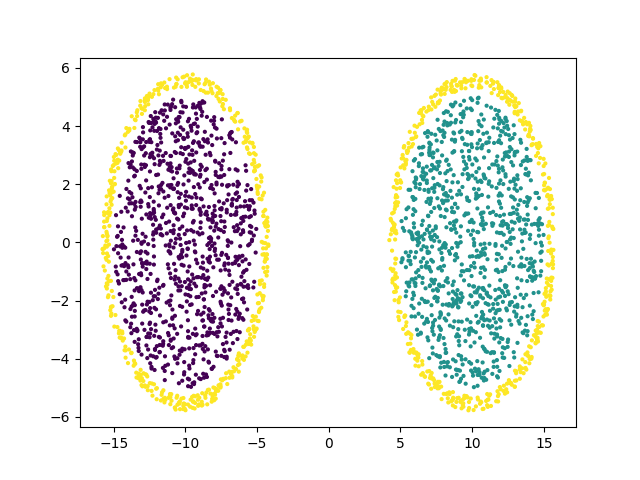

Plot of input data


In [79]:
fig = plt.figure()

plt.scatter(classifier.data[:, 0], classifier.data[:, 1], s=4, c=classifier.labels.squeeze())
plt.show()
#plt.scatter(classifier.data_outlier[:, 0], classifier.data_outlier[:, 1], s=4, c=classifier.labels_outlier.squeeze())

print("Plot of input data")

In [138]:
# Create image for paper
classifier.n = 200
data, labels = classifier.get_data()
labels = labels.squeeze()

(200, 1)
(400, 1)
(600, 1)


<IPython.core.display.Javascript object>


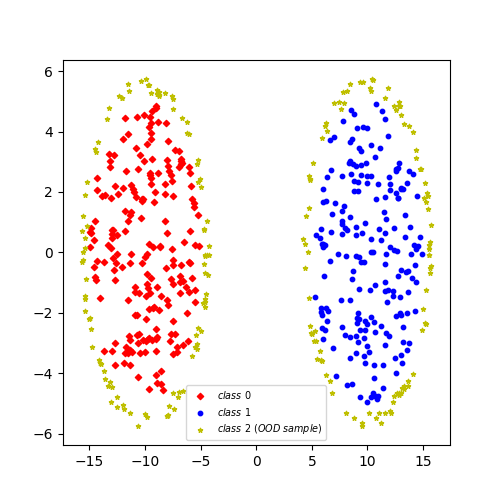

In [139]:
plt.figure(figsize=(5,5))
ind = np.where(labels == 0)[0]
plt.scatter(data[ind, 0], data[ind, 1], s=10, c='r', marker='D')
ind = np.where(labels == 1)[0]
plt.scatter(data[ind, 0], data[ind, 1], s=10, c='b', marker='o')
ind = np.where(labels == 2)[0]
plt.scatter(data[ind, 0], data[ind, 1], s=10, c='y', marker='*')
#plt.xlim(-18, +18)
#plt.ylim(-18, +18)
#plt.gca().set_aspect('equal', adjustable='box')
plt.legend(('$class\ 0$','$class\ 1$','$class\ 2\ (OOD\ sample)$'), fontsize='x-small');
plt.show()
plt.savefig("exp1_a")

<IPython.core.display.Javascript object>


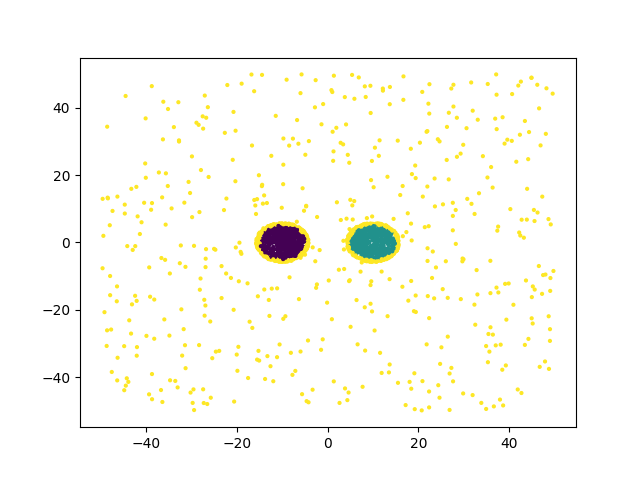

In [80]:
# Plot classified data - for test data
y_pred = classifier.model.predict(classifier.X_test)
y_labels = y_pred.argmax(axis = -1)

# take the max for inlier and 1-max for outlier class
y_max = y_pred.max(axis=-1)
ind = np.where((classifier.y_test == 2))[0]
y_max[ind] = 1-y_max[ind]

fig = plt.figure()
plt.scatter(classifier.X_test[:, 0], classifier.X_test[:, 1], s=4, c=y_labels.squeeze())

#ax = Axes3D(fig)

#ax.scatter(classifier.X_test[:, 0], classifier.X_test[:, 1], y_max, c=classifier.y_test.squeeze())
#plt.scatter(X_test[:, 0], X_test[:, 1], s=4, c=y_max.squeeze())

In [124]:
# Create image for paper
classifier.n = 400
data, labels = classifier.get_data()
ind_0 = np.where(labels==0)[0][0:50]
ind_1 = np.where(labels==1)[0][0:50]
ind_2 = np.where(labels==2)[0]
ind = np.random.randint(0, ind_2.shape[0], 50)
ind_2 = ind_2[ind]
data = np.concatenate((data[ind_0,:], data[ind_1,:], data[ind_2,:]), axis=0)
labels = np.concatenate((labels[ind_0,:], labels[ind_1,:], labels[ind_2,:]), axis=0)
data_outlier, labels_outlier = classifier.get_outlier_data()
data = np.concatenate((data, data_outlier), axis=0)
labels = np.concatenate((labels, labels_outlier))
print(data.shape)
print(labels.shape)

(400, 1)
(800, 1)
(1200, 1)
(350, 2)
(350, 1)


<IPython.core.display.Javascript object>


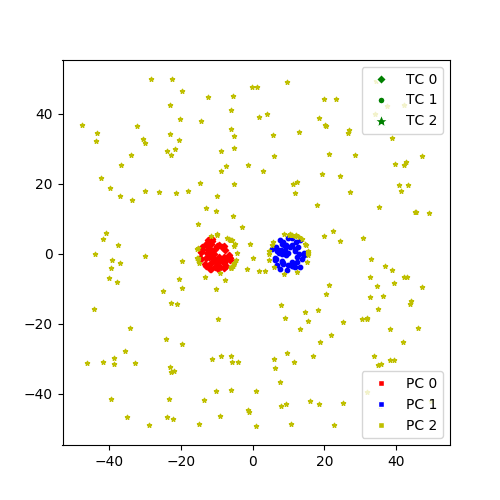

In [136]:
y_pred = classifier.model.predict(data)
y_labels = y_pred.argmax(axis = -1)
c_list = ['r', 'b', 'y']
marker_list = ['D', 'o', '*']
plt.figure(figsize=(5,5))
for i in range(0, data.shape[0]):
    marker = marker_list[int(labels[i])]
    c = c_list[y_labels[i]]
    plt.scatter(data[i, 0], data[i, 1], s=10, c=c, marker=marker)

plt.legend(('$class\ 0$','$class\ 1$','$OOD\ sample$'), fontsize='x-small');
import matplotlib.lines as lines
dimond_line = lines.Line2D([0], [0], color='w', marker='D', markerfacecolor='g',
                          markersize=5, label='TC 0')

circle_line = lines.Line2D([0], [0], marker='o', color='w', label='TC 1',
                          markerfacecolor='g', markersize=5)

star_line = lines.Line2D([0], [0], color='w', marker='*', markerfacecolor='g',
                          markersize=10, label='TC 2')


red_line = lines.Line2D([0], [0], marker='s', color='w', label='PC 0',
                          markerfacecolor='r', markersize=5)


blue_line = lines.Line2D([0], [0], marker='s', color='w', label='PC 1',
                          markerfacecolor='b', markersize=5)


yellow_line = lines.Line2D([0], [0], marker='s', color='w', label='PC 2',
                          markerfacecolor='y', markersize=5)

# Create a legend for the first line.
first_legend = plt.legend(handles=[dimond_line, circle_line, star_line], loc=1)


# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=[red_line, blue_line, yellow_line], loc=4)

plt.show()
plt.savefig("exp1_c")

In [67]:
print(classifier.X_test.shape)
print(classifier.model.evaluate(classifier.X_test, classifier.Y_test))

(200, 3)
200/200 [==============================] - 0s 99us/step
[0.015331542910911367, 0.9933333396911621]
